# Video: Testing Normalized Document Vectors for Classification

The key concern with normalizing document vectors is whether the resulting vectors are still faithful to the underlying data.
Can it be used for the same tasks as the original data?
This video will compare the performance of document vectors to their normalized versions.

Script:
* We previously evaluated document vectors for classification where each feature in the vector corresponded to a word in the training vocabulary.
* These can work well for classification problems, but we often want to normalize them for easier comparisons between documents, and so we can take advantage of fast vector databases.
* Of course, we still want these document vectors to be useful for classification, so we will assess that now.

In [ ]:
import pandas as pd

In [ ]:
recipes = pd.read_csv("https://raw.githubusercontent.com/bu-cds-omds/dx704-examples/refs/heads/main/data/recipes.tsv.gz", sep="\t")
recipe_tags = pd.read_csv("https://raw.githubusercontent.com/bu-cds-omds/dx704-examples/refs/heads/main/data/recipe-tags.tsv.gz", sep="\t")

In [ ]:
recipes = recipes.set_index("recipe_slug")
recipes

,recipe_title,recipe_introduction,recipe_ingredients,recipe_instructions,recipe_conclusion,recipe_related_slugs,recipe_ts
recipe_slug,,,,,,,
spiced-pear-and-walnut-salad,Spiced Pear And Walnut Salad,Spiced pear and walnut salad is a delicious an...,"[""2 ripe pears, thinly sliced"", ""4 cups mixed ...","[""In a small bowl, whisk together the olive oi...",\N,"[""pear-and-blue-cheese-salad"", ""walnut-and-cra...",2023-06-17 22:10:35.744536+00
roasted-pear-and-butternut-squash-soup,Roasted Pear And Butternut Squash Soup,Roasted pear and butternut squash soup is a cr...,"[""2 medium-sized butternut squash, peeled and ...","[""Preheat the oven to 400°F."", ""In a large bow...",\N,"[""roasted-butternut-squash-and-apple-soup"", ""p...",2023-06-17 22:10:46.428069+00
peach-clafoutis,Peach Clafoutis,Peach clafoutis is a classic French dessert th...,"[""4 ripe peaches, peeled and sliced"", ""3 eggs""...","[""Preheat the oven to 375°F."", ""Grease a 9-inc...",\N,"[""cherry-clafoutis"", ""blueberry-clafoutis"", ""a...",2023-06-17 19:05:50.44248+00
plum-clafoutis,Plum Clafoutis,Plum clafoutis is a classic French dessert mad...,"[""4-5 ripe plums, pitted and sliced"", ""3 eggs""...","[""Preheat the oven to 375°F (190°C) and butter...",\N,"[""cherry-clafoutis"", ""apple-clafoutis"", ""blueb...",2023-06-17 19:05:42.705122+00
pear,Pear,Pears are a sweet and juicy fruit that come in...,"[""1 sheet of puff pastry"", ""2 ripe pears, peel...","[""Preheat the oven to 400°F."", ""Roll out the p...",\N,"[""pear-and-goat-cheese-salad"", ""pear-and-ginge...",2023-06-17 22:11:13.760378+00
...,...,...,...,...,...,...,...
pear-coffee-cake,Pear Coffee Cake,Description: \nPear coffee cake is a moist an...,"[""2 cups all-purpose flour"", ""1 cup granulated...","[""Preheat your oven to 350°F (175°C). Grease a...",\N,"[""apple-cinnamon-coffee-cake"", ""banana-nut-bre...",2025-07-16 22:22:02.711138+00
elegant-pear-coffee-loaf,Elegant Pear Coffee Loaf,Description: \nThe Elegant Pear Coffee Loaf i...,"[""2 ripe pears, peeled, cored, and chopped"", ""...","[""Preheat your oven to 350°F (175°C). Grease a...",\N,"[""pear-and-walnut-coffee-cake"", ""coffee-infuse...",2025-07-16 22:22:18.463873+00
halibut,Halibut,"Description: \nHalibut is a large, flat fish ...","[""4 halibut fillets (6 oz each)"", ""Salt and fr...","[""Pat the halibut fillets dry and season gener...",\N,"[""lemon-herb-baked-halibut"", ""grilled-halibut-...",2025-07-17 20:40:05.664215+00


In [ ]:
desserts = recipe_tags.query("recipe_tag == 'dessert'").set_index("recipe_slug")
dessert_target = pd.DataFrame({"dessert": recipes.index.isin(desserts.index).astype(int)}, index=recipes.index)
dessert_target

,dessert
recipe_slug,
spiced-pear-and-walnut-salad,0
roasted-pear-and-butternut-squash-soup,0
peach-clafoutis,1
plum-clafoutis,1
pear,1
...,...
pear-coffee-cake,0
elegant-pear-coffee-loaf,1
halibut,0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(recipes["recipe_introduction"])
X_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5533341 stored elements and shape (97047, 7918)>

Script:
* I already prepared our bag of words representation.
* Let's normalize those to unit vectors now.

In [ ]:
def normalize_features(X):
    return X / np.sqrt(np.sum(X.multiply(X), axis=1))

In [ ]:
import numpy as np

In [ ]:
X_bow_norm = normalize_features(X_bow)
X_bow_norm

<COOrdinate sparse matrix of dtype 'float64'
	with 5533341 stored elements and shape (97047, 7918)>

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_bow_norm = LogisticRegression()
model_bow_norm.fit(X_bow_norm, dessert_target["dessert"])

LogisticRegression()

In [ ]:
bow_norm_predictions = model_bow_norm.predict(X_bow_norm)
(bow_norm_predictions == dessert_target["dessert"]).mean()

np.float64(0.9558873535503416)

Script:
* What about term frequency?
* The rescaling for term frequency does not matter if we normalize afterwards.
* So bag of words and term frequency will behave exactly the same after normalization to unit vectors because they produce the same unit vectors.
* What about term frequency inverse document frequency or TF-IDF?
* Previously, when using logistic regressions, I said scaling by inverse document frequency just changed the constants in the linear component of logistic regression.
* But if we use it with normalization too, some of those changes will survive.
* Let's try it now.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

Script:
* Scikit-learn has a builtin class to handle encoding TF-IDF features, so we don't need to compute separate document frequencies and combine with the previous counts.

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(recipes["recipe_introduction"])
X_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5533341 stored elements and shape (97047, 7918)>

Script:
* The resulting sparse feature matrix has the same dimensions and number of entries, but now they won't all be integers because of the IDF scaling.
* Let's compute the logistic regression now.

In [ ]:
X_tfidf_norm = normalize_features(X_tfidf)
X_tfidf_norm

<COOrdinate sparse matrix of dtype 'float64'
	with 5533341 stored elements and shape (97047, 7918)>

In [ ]:
model_tfidf_norm = LogisticRegression()
model_tfidf_norm.fit(X_tfidf_norm, dessert_target["dessert"])

LogisticRegression()

In [ ]:
tfidf_norm_predictions = model_tfidf_norm.predict(X_tfidf_norm)
(tfidf_norm_predictions == dessert_target["dessert"]).mean()

np.float64(0.9581130792296516)

Script:
* It's almost as good as the unnormalized bag of words that we previously saw.
* About half a percent behind.
* Or about 90% of the gain over the flat predictions.

In [ ]:
import matplotlib.pyplot as plt

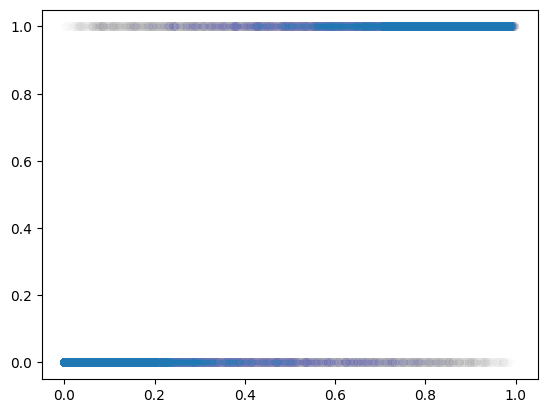

In [ ]:
tfidf_norm_probabilities = model_tfidf_norm.predict_proba(X_tfidf_norm)[:,1]
plt.scatter(tfidf_norm_probabilities, dessert_target["dessert"], alpha=0.005);

Script:
* If we plot the probabilities again, we see a different mix.
* Both desserts and non-desserts have tighter ranges of predictions.
* Both have mistakes and uncertainty, and there is some asymmetry.
* Non-desserts have predictions mostly between 10 and 60% while desserts have predictions mostly between 50% and 70%.
* So there is less confidence predicting the rarer desserts.

Script: (faculty on screen)
* When considering normalizing our document vectors for comparisons and vector databases, we needed to check whether we could maintain accuracy.
* In this simple study, we found that we could keep most of the dessert classification accuracy.